## Inventory Forecasting using RNN(LSTM)

* For academic purpose, we are forecasting for one spare parts requirement only.
* Similar method can be followed to forecast rest of the spare parts.

In [ ]:


# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Importing the training set
dataset_total = pd.read_excel('AIR_FILTER.xlsx')
dataset_total.head(3)

,Date,Item
0,2017-06-04,21
1,2017-06-11,38
2,2017-06-18,42


In [3]:
dataset_total.shape

(84, 2)

In [4]:
train_ds_count = 70
test_ds_count  = 14
rnn_lag = 12

In [5]:
dataset_train = dataset_total[:train_ds_count]
dataset_test  = dataset_total[train_ds_count:]

training_set = dataset_train.iloc[:, 1:2].values

In [6]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


In [7]:
# Creating a data structure with rnn_lag(12) timesteps and 1 output
X_train = []
y_train = []
for i in range(rnn_lag, train_ds_count):
    X_train.append(training_set_scaled[i-rnn_lag:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)



In [8]:
# Reshaping
# The value 1 here indicates we are using only one predictor.
# keras RNN expects data structure in 3 dimenstions as per keras documentation
# (No. of weeks of data(54, last 30 used for prediction), No. of timesteps/lag(30)),  no of predictors)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



### Building the RNN

In [9]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [10]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 16, return_sequences = True, 
                   input_shape = (X_train.shape[1], 1)))
#regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 16, return_sequences = True))
#regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 16, return_sequences = True))
#regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 16))
#regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [11]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 4)



Epoch 1/100
58/58 [==============================] - 7s 121ms/step - loss: 0.3184
Epoch 2/100
58/58 [==============================] - 1s 15ms/step - loss: 0.0530
Epoch 3/100
58/58 [==============================] - 1s 14ms/step - loss: 0.0357
Epoch 4/100
58/58 [==============================] - 1s 14ms/step - loss: 0.0312
Epoch 5/100
58/58 [==============================] - 1s 14ms/step - loss: 0.0263
Epoch 6/100
58/58 [==============================] - 1s 15ms/step - loss: 0.0274
Epoch 7/100
58/58 [==============================] - 1s 15ms/step - loss: 0.0257
Epoch 8/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0273
Epoch 9/100
58/58 [==============================] - 1s 15ms/step - loss: 0.0257
Epoch 10/100
58/58 [==============================] - 1s 15ms/step - loss: 0.0272
Epoch 11/100
58/58 [==============================] - 1s 15ms/step - loss: 0.0277
Epoch 12/100
58/58 [==============================] - 1s 15ms/step - loss: 0.0256
Epoch 13/100
58/58 [====

58/58 [==============================] - 1s 14ms/step - loss: 0.0264
Epoch 100/100
58/58 [==============================] - 1s 14ms/step - loss: 0.0262


### Making the predictions and visualising the results

In [12]:

#dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_item_count = dataset_test.iloc[:, 1:2].values


dataset_total = pd.concat((dataset_train['Item'], dataset_test['Item']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - rnn_lag:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [13]:
inputs.shape

(26, 1)

In [14]:
X_test = []
for i in range(rnn_lag, rnn_lag + test_ds_count):
    X_test.append(inputs[i-rnn_lag:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [15]:
predicted_item_count = regressor.predict(X_test)
predicted_item_count = sc.inverse_transform(predicted_item_count)


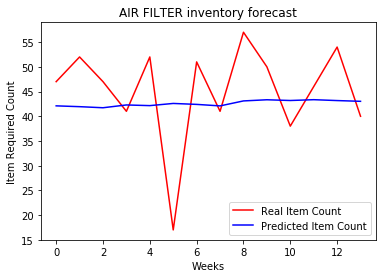

In [16]:
# Visualising the results
plt.plot(real_item_count, color = 'red', label = 'Real Item Count')
plt.plot(predicted_item_count, color = 'blue', label = 'Predicted Item Count')
plt.title('AIR FILTER inventory forecast')
plt.xlabel('Weeks')
plt.ylabel('Item Required Count')
plt.legend()


### Evaluating the model

In [ ]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_item_count, predicted_item_count))

# rmse value of 50 is very high if the stock predicted stock price 
# are in the range 100, and very small if the it is 10000 range.
# In our case, Jan2017 price is in the 800 range, rmse/800 is the relative error.
rmse